DS Talent Fair - Hacktiv8 Indonesia

# Computer Price Forecasting
by Fathiyah Kalamal Haq

**Objektif:**
1. Mencari produk dan brand paling diminati
2. Melakukan peramalan harga produk yang paling banyak diminati

Dataset yang digunakan merupakan dataset dari sebuah perusahaan ecommerce yang menjual berbagai jenis produk. Terdapat data mengenai produk yang terjual, dimasukkan kedalam keranjang dan yang hanya dilihat saja. Dalam melakukan forecasting, model yang digunakan adalah dengan model ARIMA.

# Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pd.read_csv("/content/drive/MyDrive/first question/user-events.csv")
df.tail()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
885124,2021-02-28 23:55:01 UTC,view,953226,2144415927553229037,NaN,NaN,219.94,1515915625611023730,FRLqIttxKU
885125,2021-02-28 23:58:05 UTC,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma
885126,2021-02-28 23:58:09 UTC,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd
885127,2021-02-28 23:58:14 UTC,view,888273,2144415921932861531,electronics.telephone,NaN,10.16,1515915625611024030,9pCbKMIcSx
885128,2021-02-28 23:59:09 UTC,view,743182,2144415935631458761,construction.tools.soldering,kada,65.08,1515915625556087775,BejOXRngEW


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885129 entries, 0 to 885128
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   event_time     885129 non-null  object 
 1   event_type     885129 non-null  object 
 2   product_id     885129 non-null  int64  
 3   category_id    885129 non-null  int64  
 4   category_code  648910 non-null  object 
 5   brand          672765 non-null  object 
 6   price          885129 non-null  float64
 7   user_id        885129 non-null  int64  
 8   user_session   884964 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 60.8+ MB


In [16]:
data=df.copy()

In [17]:
print("data duplikat: ",df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("data duplikat setelah drop: ",df.duplicated().sum())

data duplikat:  655
data duplikat setelah drop:  0


In [18]:
pd.DataFrame({
    "Unique": df.nunique(),
    "missing value": df.isnull().sum(),
    "%": (df.isnull().sum()/df.shape[0])*100
})

,Unique,missing value,%
event_time,845041,0,0.000000
event_type,3,0,0.000000
product_id,53453,0,0.000000
category_id,718,0,0.000000
category_code,107,236047,26.687839
brand,999,212232,23.995279
price,12422,0,0.000000
user_id,407283,0,0.000000
user_session,490398,162,0.018316


Data yang kosong terdapat pada kolom `user_session`, `brand`,`category_code	`.

# EDA

# Tipe User

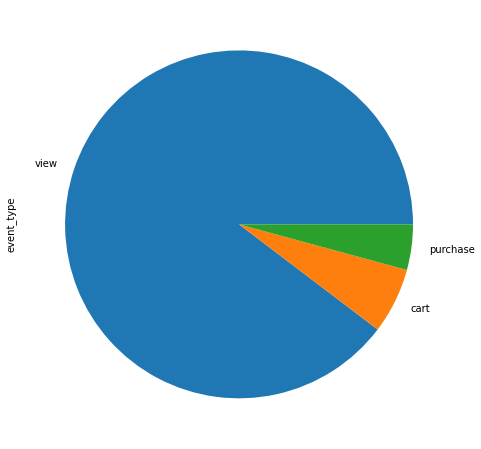

In [20]:
df.event_type.value_counts().plot(kind='pie',figsize = (8,8))

Pengunjung web yang melakukan purchase sangat sedikit jika dibandingkan dengan yang melihat-lihat saja. Begitu pula dengan produk yang dimasukkan kedalam keranjang.

# Penjualan dari waktu ke waktu

In [21]:
#merubah kolom pertama menjadi format datetime
df['event_time'] = pd.to_datetime(df["event_time"])
df['event_date'] = df.event_time.dt.date
df['event_year'] = df.event_time.dt.year
df['event_month'] = df.event_time.dt.month
df['event_day'] = df.event_time.dt.day

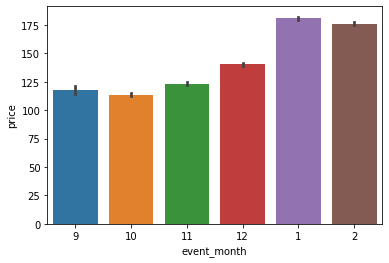

In [22]:
sns.barplot(x = 'event_month',y = 'price',data=df, order=[9,10,11,12,1,2])

harga barang mengalami tren positif setiap bulannya (dari sep 2020 - feb 2021)

In [23]:
df_purchase = df[df.event_type=="purchase"]
df_view= df[df.event_type=="view"]
df_cart= df[df.event_type=="cart"]

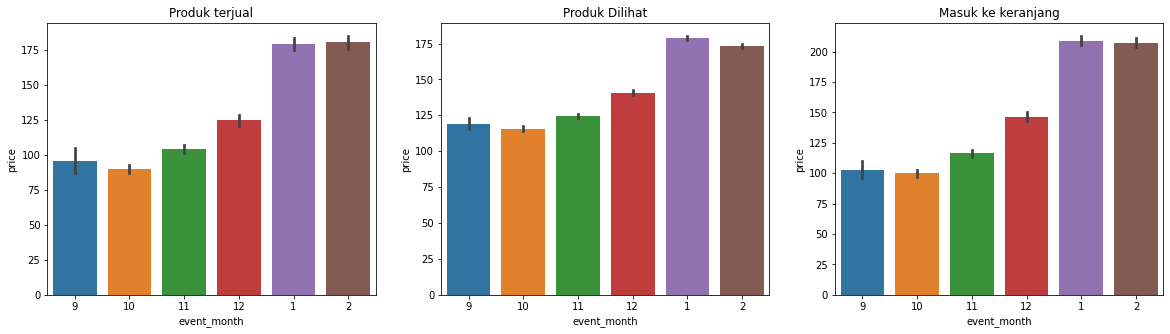

In [24]:
f,ax = plt.subplots(ncols=3, figsize=(20,5))
sns.barplot(x = 'event_month',y = 'price',data=df_purchase, order=[9,10,11,12,1,2],ax=ax[0])
ax[0].set_title('Produk terjual')
sns.barplot(x = 'event_month',y = 'price',data=df_view, order=[9,10,11,12,1,2],ax=ax[1])
ax[1].set_title('Produk Dilihat')
sns.barplot(x = 'event_month',y = 'price',data=df_cart, order=[9,10,11,12,1,2],ax=ax[2])
ax[2].set_title('Masuk ke keranjang')
plt.show()

rata-rata penjualan produk tiap bulannya mengalami tren positif, terjadi kenaikan secara signifikan dari awal hingga akhir bulan. Penjualan tertinggi berada pada bulan februari 2021 untuk produk yang terjual. Sedangkan rata-rata Produk yang hanya dilihat dan masuk dalam keranjang tertingginya berada di bulan januari 2021.

In [25]:
df_purchase[['event_month','price']].groupby("event_month").agg(["sum",'mean'])

price            
                    sum        mean
event_month                        
1            1488410.57  179.003075
2            1376805.70  180.163007
9              96353.01   95.683227
10            562590.39   89.641554
11            787886.24  104.025118
12            813068.01  124.531783

# Data Preprocessing

## Handling Missing Value

In [26]:
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    236047
brand            212232
price                 0
user_id               0
user_session        162
event_date            0
event_year            0
event_month           0
event_day             0
dtype: int64

In [27]:
162/df.shape[0]

0.00018315970848210348

Missing Value pada fitur user_session sekitar 0.01% dari dataset sehingga akan dilakukan penghapusan data yang missing pada user_session. Namun untuk fitur category code dan brand missing value >20% sehingga diperlukan kajian lebih dalam mengenai sifat missing value disini apakah MNAR, MCAR atau MAR.

### Drop Missing Value Pada `user_session`

In [28]:
df[df.user_session.isnull()==True].index

Int64Index([  2257,   6872,   7898,  11782,  24461,  28431,  29688,  32660,
             36283,  48462,
            ...
            709335, 709352, 709354, 788036, 791602, 796271, 808622, 808625,
            808626, 826870],
           dtype='int64', length=162)

In [29]:
# drop missing value pada fitur user_session
df.drop(df[df.user_session.isnull()==True].index, axis=0,inplace=True)

In [30]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_year,event_month,event_day
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT,2020-09-24,2020,9,24
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2020-09-24,2020,9,24
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy,2020-09-24,2020,9,24
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2020-09-24,2020,9,24
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020-09-24,2020,9,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885124,2021-02-28 23:55:01+00:00,view,953226,2144415927553229037,NaN,NaN,219.94,1515915625611023730,FRLqIttxKU,2021-02-28,2021,2,28
885125,2021-02-28 23:58:05+00:00,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma,2021-02-28,2021,2,28
885126,2021-02-28 23:58:09+00:00,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd,2021-02-28,2021,2,28
885127,2021-02-28 23:58:14+00:00,view,888273,2144415921932861531,electronics.telephone,NaN,10.16,1515915625611024030,9pCbKMIcSx,2021-02-28,2021,2,28


jumlah data berkurang menjadi 884312 baris

### Missing Value >20%

In [31]:
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    236001
brand            212194
price                 0
user_id               0
user_session          0
event_date            0
event_year            0
event_month           0
event_day             0
dtype: int64

In [32]:
print(df[(df.category_code.isnull()==True)& (df.brand.isnull()==True)].shape[0]/df.shape[0])
print(df[(df.category_code.isnull()==False)& (df.brand.isnull()==True)].shape[0]/df.shape[0])
print(df[(df.category_code.isnull()==True)& (df.brand.isnull()==False)].shape[0]/df.shape[0])

0.09016953292503098
0.14978423904685223
0.17670573281828134


Missing value pada kedua fitur adalah 9% dan pada masing-masing fitur berkisar 14-17% sehingga untuk yang terdapat NaN pada kedua fitur akan dilakukan drop data, sedangkan untuk missing value pada masing-masing fitur akan dilakukan input silang.

In [33]:
# drop values yang kosong pada kedua fitur
df.drop(df[(df.category_code.isnull()==True)& (df.brand.isnull()==True)].index,axis=0, inplace=True)

In [34]:
df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    156263
brand            132456
price                 0
user_id               0
user_session          0
event_date            0
event_year            0
event_month           0
event_day             0
dtype: int64

In [35]:
# cross-filling
df['category_code'].fillna(value = df[df.category_code.isnull()==True]['brand'],inplace = True)
df.brand.fillna(value = df[df.brand.isnull()==True]['category_code'],inplace=True)

In [36]:
df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
event_date       0
event_year       0
event_month      0
event_day        0
dtype: int64

Sekarang dataset sudah bersih dari missing values

## Handling Outliers

Cara mudah mendeteksi outlier adalah dengan melakukan visualisasi dengan boxplot. Pada dataset ini, terdapat fitur numerik yaitu `price`. Beberapa tipe data numerik lainnya seperti tanggal dan id tidak akan dicek outliernya karena tidak digunakan dalam perhitungan model.

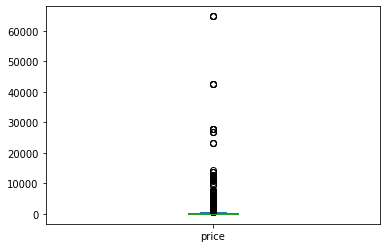

In [37]:
df['price'].plot(kind='box')

terdeteksi outlier pada fitur `price`. Nilai terjauhnya adalah diatas 60000. Walaupun masih normal dalam konteks harga barang, namun hal ini mampu merubah hasil model menjadi rancu dan tidak sesuai dengan hasil yang diinginkan. Sehingga outlier ini harus diatasi.

In [38]:
q1 = np.percentile(df.price,25)
q3 = np.percentile(df.price,75)
iqr = q3-q1
low = q1-3*iqr
up = q3+3*iqr

In [39]:
df[(df.price<low)|(df.price>up)].shape[0]/df.shape[0]

0.018775153062365924

outlier yang terdeteksi adalah sekitar 1,8%. Outlier akan didrop dari dataset

In [40]:
df_clean = df.drop(df[(df.price<low)|(df.price>up)].index, axis=0)
df_clean

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_year,event_month,event_day
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,electronics.telephone,31.90,1515915625519388267,LJuJVLEjPT,2020-09-24,2020,9,24
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2020-09-24,2020,9,24
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2020-09-24,2020,9,24
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,cameronsino,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020-09-24,2020,9,24
5,2020-09-24 11:57:59+00:00,view,664325,2144415951611757447,construction.tools.saw,carver,52.33,1515915625519388062,vnkdP81DDW,2020-09-24,2020,9,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885123,2021-02-28 23:54:18+00:00,view,3829355,2144415922528452715,electronics.telephone,electronics.telephone,32.22,1515915625611023671,wZb7gP1zgN,2021-02-28,2021,2,28
885125,2021-02-28 23:58:05+00:00,view,1715907,2144415927049912542,electronics.video.tv,starwind,80.03,1515915625611024014,g6WqPf50Ma,2021-02-28,2021,2,28
885126,2021-02-28 23:58:09+00:00,view,4170534,2144415939364389423,electronics.clocks,amazfit,64.92,1515915625611024020,xNIJBqZdkd,2021-02-28,2021,2,28
885127,2021-02-28 23:58:14+00:00,view,888273,2144415921932861531,electronics.telephone,electronics.telephone,10.16,1515915625611024030,9pCbKMIcSx,2021-02-28,2021,2,28


## Feature extraction

Fitur kategori sebelumnya berbentuk gabungan beberapa kata, namun cukup diambil bagian kategori umumnya saja untuk fitur `category_code` sedangkan untuk fitur `brand` akan diambil kategori khususnya.

In [41]:
df_clean.category_code = df_clean.category_code.apply(lambda x: x.split(".")[0])
df_clean.brand = df_clean.brand.apply(lambda x: x.split(".")[-1])

In [42]:
df_clean

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_year,event_month,event_day
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics,telephone,31.90,1515915625519388267,LJuJVLEjPT,2020-09-24,2020,9,24
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers,zalman,17.16,1515915625519380411,tdicluNnRY,2020-09-24,2020,9,24
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers,pantum,113.81,1515915625519014356,aGFYrNgC08,2020-09-24,2020,9,24
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,cameronsino,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020-09-24,2020,9,24
5,2020-09-24 11:57:59+00:00,view,664325,2144415951611757447,construction,carver,52.33,1515915625519388062,vnkdP81DDW,2020-09-24,2020,9,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885123,2021-02-28 23:54:18+00:00,view,3829355,2144415922528452715,electronics,telephone,32.22,1515915625611023671,wZb7gP1zgN,2021-02-28,2021,2,28
885125,2021-02-28 23:58:05+00:00,view,1715907,2144415927049912542,electronics,starwind,80.03,1515915625611024014,g6WqPf50Ma,2021-02-28,2021,2,28
885126,2021-02-28 23:58:09+00:00,view,4170534,2144415939364389423,electronics,amazfit,64.92,1515915625611024020,xNIJBqZdkd,2021-02-28,2021,2,28
885127,2021-02-28 23:58:14+00:00,view,888273,2144415921932861531,electronics,telephone,10.16,1515915625611024030,9pCbKMIcSx,2021-02-28,2021,2,28


### Produk Paling Diminati

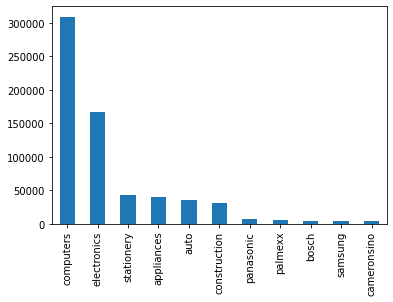

In [43]:
df_clean.category_code.value_counts()[0:11].plot(kind='bar')

Produk komputer merupakan produk yang paling diminati

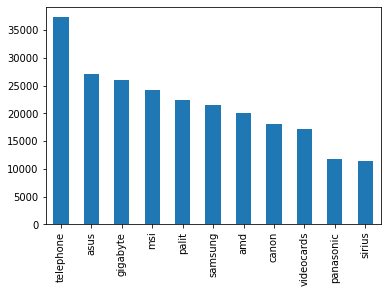

In [44]:
df_clean.brand.value_counts()[0:11].plot(kind='bar')

Telephone disini bukanlah brand namun hasil dari input silang sebelumnya sehingga bisa dikesampingkan. Brand asus adalah brand yang paling diminati. Jadi kesimpulannya, produk-produk komputer tinggi peminat dan brand yang paling banyak diminati adalah brand asus.

# Model Definition

Komputer adalah produk yang paling banyak diminati sehingga dibuatlah model untuk meramalkan harga komputer di masa yang akan datang

In [47]:
comp = df_clean[df_clean.category_code=='computers']
comp

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,event_year,event_month,event_day
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers,zalman,17.16,1515915625519380411,tdicluNnRY,2020-09-24,2020,9,24
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers,pantum,113.81,1515915625519014356,aGFYrNgC08,2020-09-24,2020,9,24
6,2020-09-24 11:58:23+00:00,view,3791349,2144415935086199225,computers,desktop,215.41,1515915625519388877,J1t6sIYXiV,2020-09-24,2020,9,24
7,2020-09-24 11:58:24+00:00,view,716611,2144415923694469257,computers,d-link,53.14,1515915625519388882,kVBeYDPcBw,2020-09-24,2020,9,24
9,2020-09-24 11:58:31+00:00,view,716611,2144415923694469257,computers,d-link,53.14,1515915625519388929,F3VB9LYp39,2020-09-24,2020,9,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885113,2021-02-28 23:45:38+00:00,view,4079420,2144415922427789416,computers,msi,449.51,1515915625611018641,So7HVPEawt,2021-02-28,2021,2,28
885118,2021-02-28 23:51:06+00:00,view,3759378,2144415927972659448,computers,dockcase,50.16,1515915625611023376,GheawAs525,2021-02-28,2021,2,28
885120,2021-02-28 23:51:25+00:00,view,622796,2144415922738167921,computers,asus,147.38,1515915625572947504,LJ4H6CRcME,2021-02-28,2021,2,28
885121,2021-02-28 23:51:25+00:00,view,622796,2144415922738167921,computers,asus,147.38,1515915625572947504,SqlXaC3Wrw,2021-02-28,2021,2,28


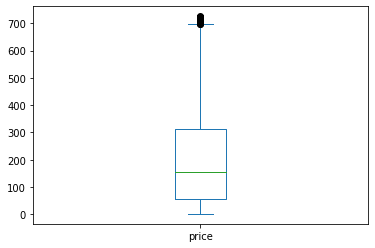

In [48]:
comp[['event_date','price']].plot(kind='box')

In [49]:
from statsmodels.tsa.arima_model import ARIMA


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


model yang digunakan untuk meramal harga komputer adalah model ARIMA

In [50]:
comprice = comp[['event_date','price']]
comprice.set_index('event_date', inplace=True)
comprice.index = pd.DatetimeIndex(comprice.index).to_period('M')

In [51]:
comprice

,price
event_date,
2020-09,17.16
2020-09,113.81
2020-09,215.41
2020-09,53.14
2020-09,53.14
...,...
2021-02,449.51
2021-02,50.16
2021-02,147.38


# Model Training and Evaluation

Dalam mencari model terbaik maka akan digunakan AIC untuk meninjau model ARIMA terbaik. Makin kecil nilai AIC makin baik pula performa model.

In [52]:
mod110 = ARIMA(comprice, order=(1,1,0))

In [53]:
res110=mod110.fit()
print('The AIC is',res110.aic)

The AIC is 4098888.9904785845


In [54]:
mod100 = ARIMA(comprice, order=(1,0,0))

In [55]:
res100=mod100.fit()
print('The AIC is',res100.aic)

The AIC is 4032994.2477302006


In [56]:
mod001 = ARIMA(comprice, order=(0,0,1))
res001=mod001.fit()
print('The AIC is',res001.aic)

The AIC is 4038151.98728722


In [57]:
mod011 = ARIMA(comprice, order=(0,1,1))
res011=mod011.fit()
print('The AIC is',res011.aic)

The AIC is 4016959.855649614


In [58]:
mod111 = ARIMA(comprice, order=(1,1,1))
res111=mod111.fit()
print('The AIC is',res111.aic)

The AIC is 4012782.324095536


In [59]:
mod112 = ARIMA(comprice, order=(1,1,2))
res112=mod112.fit()
print('The AIC is',res112.aic)

The AIC is 4008045.3966876687


In [65]:
mod115 = ARIMA(comprice, order=(1,1,5))
res115=mod115.fit()
print('The AIC is',res115.aic)

The AIC is 4007722.4759692447


In [69]:
mod116 = ARIMA(comprice, order=(1,1,6))
res116=mod116.fit()
print('The AIC is',res116.aic)

The AIC is 4007679.7611203976


# Visualisasi model ARIMA

Berikut adalah beberapa plot model ARIMA:
1. ARIMA (1,1,6) dengan AIC sebesar 4007679.7611203976
Sejauh ini model ini adalah model yang memiliki nilai AIC terkecil. Jika dilihat dari plotnya, model yang didapat masih underfitting dengan model aslinya. Hasil peramalan harga komputer 2 bulan kedepan menunjukkan penurunan yang signifikan.

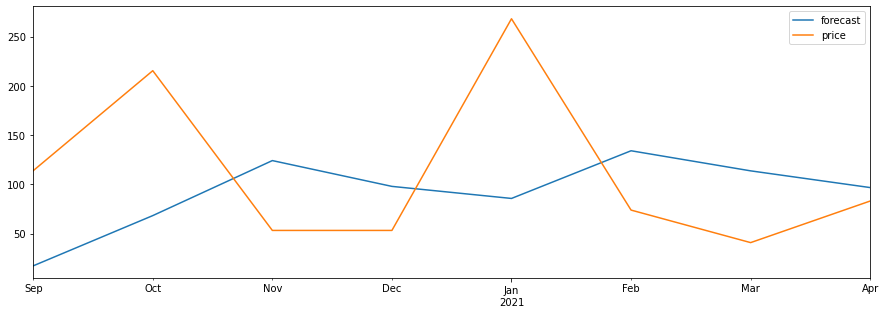

In [70]:
fig,ax=plt.subplots(figsize=(15,5))
res116.plot_predict(start='2020-09', end=comprice.index[-1]+2,ax=ax)
plt.show()

2. ARIMA(1,1,5)
Hasil plot model ini juga menunjukkan model yang underfitting, namun model dapat mengikuti pola tren positif dari model aslinya. Hasil peramalan dari model ini untuk 2 bulan kedepan adalah mengalami penurunan.

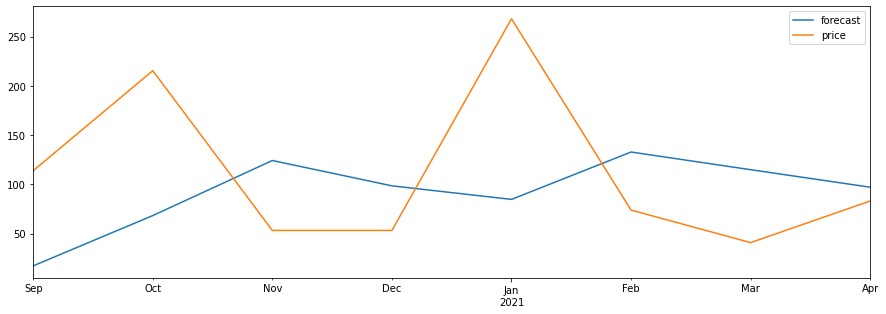

In [66]:
fig,ax=plt.subplots(figsize=(15,5))
res115.plot_predict(start='2020-09', end=comprice.index[-1]+2,ax=ax)
plt.show()

3. ARIMA (1,1,1) juga menunjukkan performa model yang underfitting melihat besarnya perbedaan dengan data asli. Tidak jauh berbeda dengan model ARIMA(1,1,5)

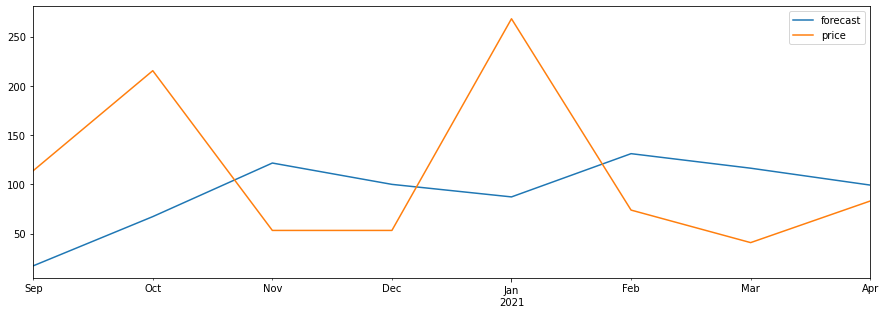

In [62]:
fig,ax=plt.subplots(figsize=(15,5))
res111.plot_predict(start='2020-09', end=comprice.index[-1]+2,ax=ax)
plt.show()

4. ARIMA(0,0,1) hasilnya jauh berbeda dengan data harga komputer yang asli dan nilai penurunannya lebih curam dari model yang lain namun prediksinya tertinggi yaitu berada di atas 150

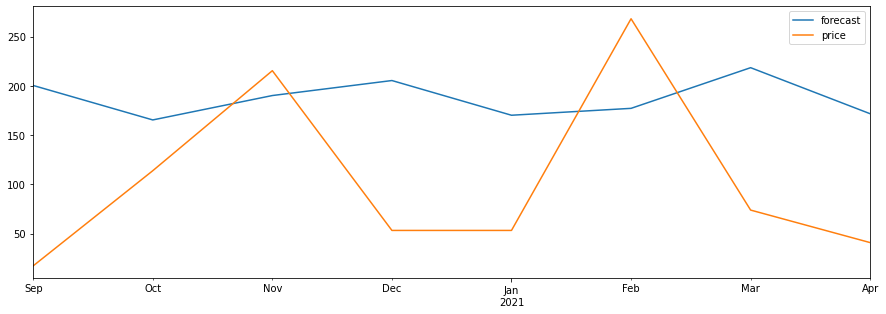

In [63]:
fig,ax=plt.subplots(figsize=(15,5))
res001.plot_predict(start='2020-09', end=comprice.index[-1]+2,ax=ax)
plt.show()

# Conclusion

1. Kebanyakan pengunjung web hanya melihat-lihat barang saja, hanya sedikit yang melakukan transaksi.
2. Rata-rata penjualan produk terjadi pada bulan Februari 2021
3. Produk-produk komputer adalah produk yang paling banyak diminati, brand komputer yang sedang digandrungi adalah brand asus.
4. model ARIMA dengan AIC terendah adalah ARIMA(1,1,6)
5. Harga penjualan komputer pada bulan Maret dan April 2021 adalah 110 dan 100. Menurun dari bulan-bulan sebelumnya
